In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from tqdm.notebook import tqdm
warnings.filterwarnings('ignore')
%matplotlib inline

import tensorflow as tf
from tensorflow.keras.utils import load_img
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D, Input

In [4]:
BASE_DIR = '../input/utkface-new/UTKFace/'

In [5]:
# labels - age, gender, ethnicity
image_paths = []
age_labels = []
gender_labels = []

for filename in tqdm(os.listdir(BASE_DIR)):
    image_path = os.path.join(BASE_DIR, filename)
    temp = filename.split('_')
    age = int(temp[0])
    gender = int(temp[1])
    image_paths.append(image_path)
    age_labels.append(age)
    gender_labels.append(gender)

  0%|          | 0/23708 [00:00<?, ?it/s]

In [6]:
# convert to dataframe
df = pd.DataFrame()
df['image'], df['age'], df['gender'] = image_paths, age_labels, gender_labels
df.head()

image  age  gender
0  ../input/utkface-new/UTKFace/26_0_2_2017010402...   26       0
1  ../input/utkface-new/UTKFace/22_1_1_2017011223...   22       1
2  ../input/utkface-new/UTKFace/21_1_3_2017010500...   21       1
3  ../input/utkface-new/UTKFace/28_0_0_2017011718...   28       0
4  ../input/utkface-new/UTKFace/17_1_4_2017010322...   17       1

In [7]:
# map labels for gender
gender_dict = {0:'Male', 1:'Female'}

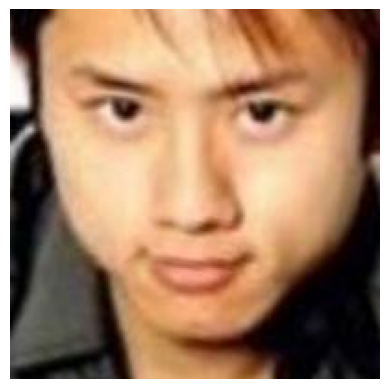

In [8]:
from PIL import Image
img = Image.open(df['image'][0])
plt.axis('off')
plt.imshow(img);

<Axes: xlabel='age', ylabel='Density'>

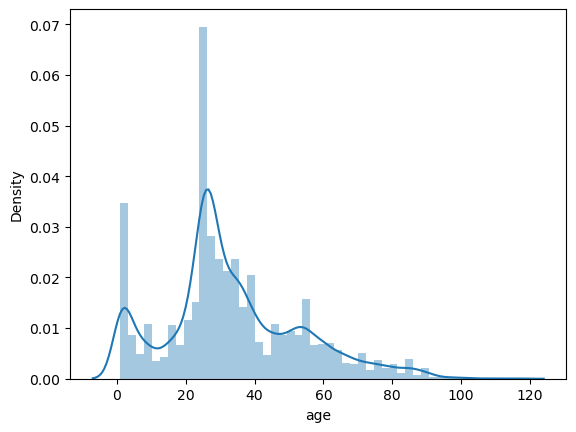

In [9]:
sns.distplot(df['age'])

<Axes: ylabel='count'>

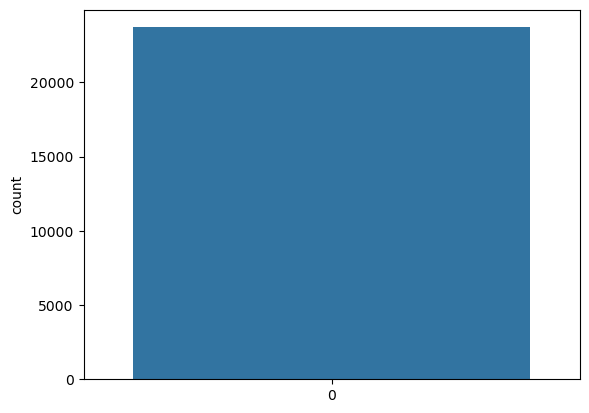

In [10]:
sns.countplot(df['gender'])

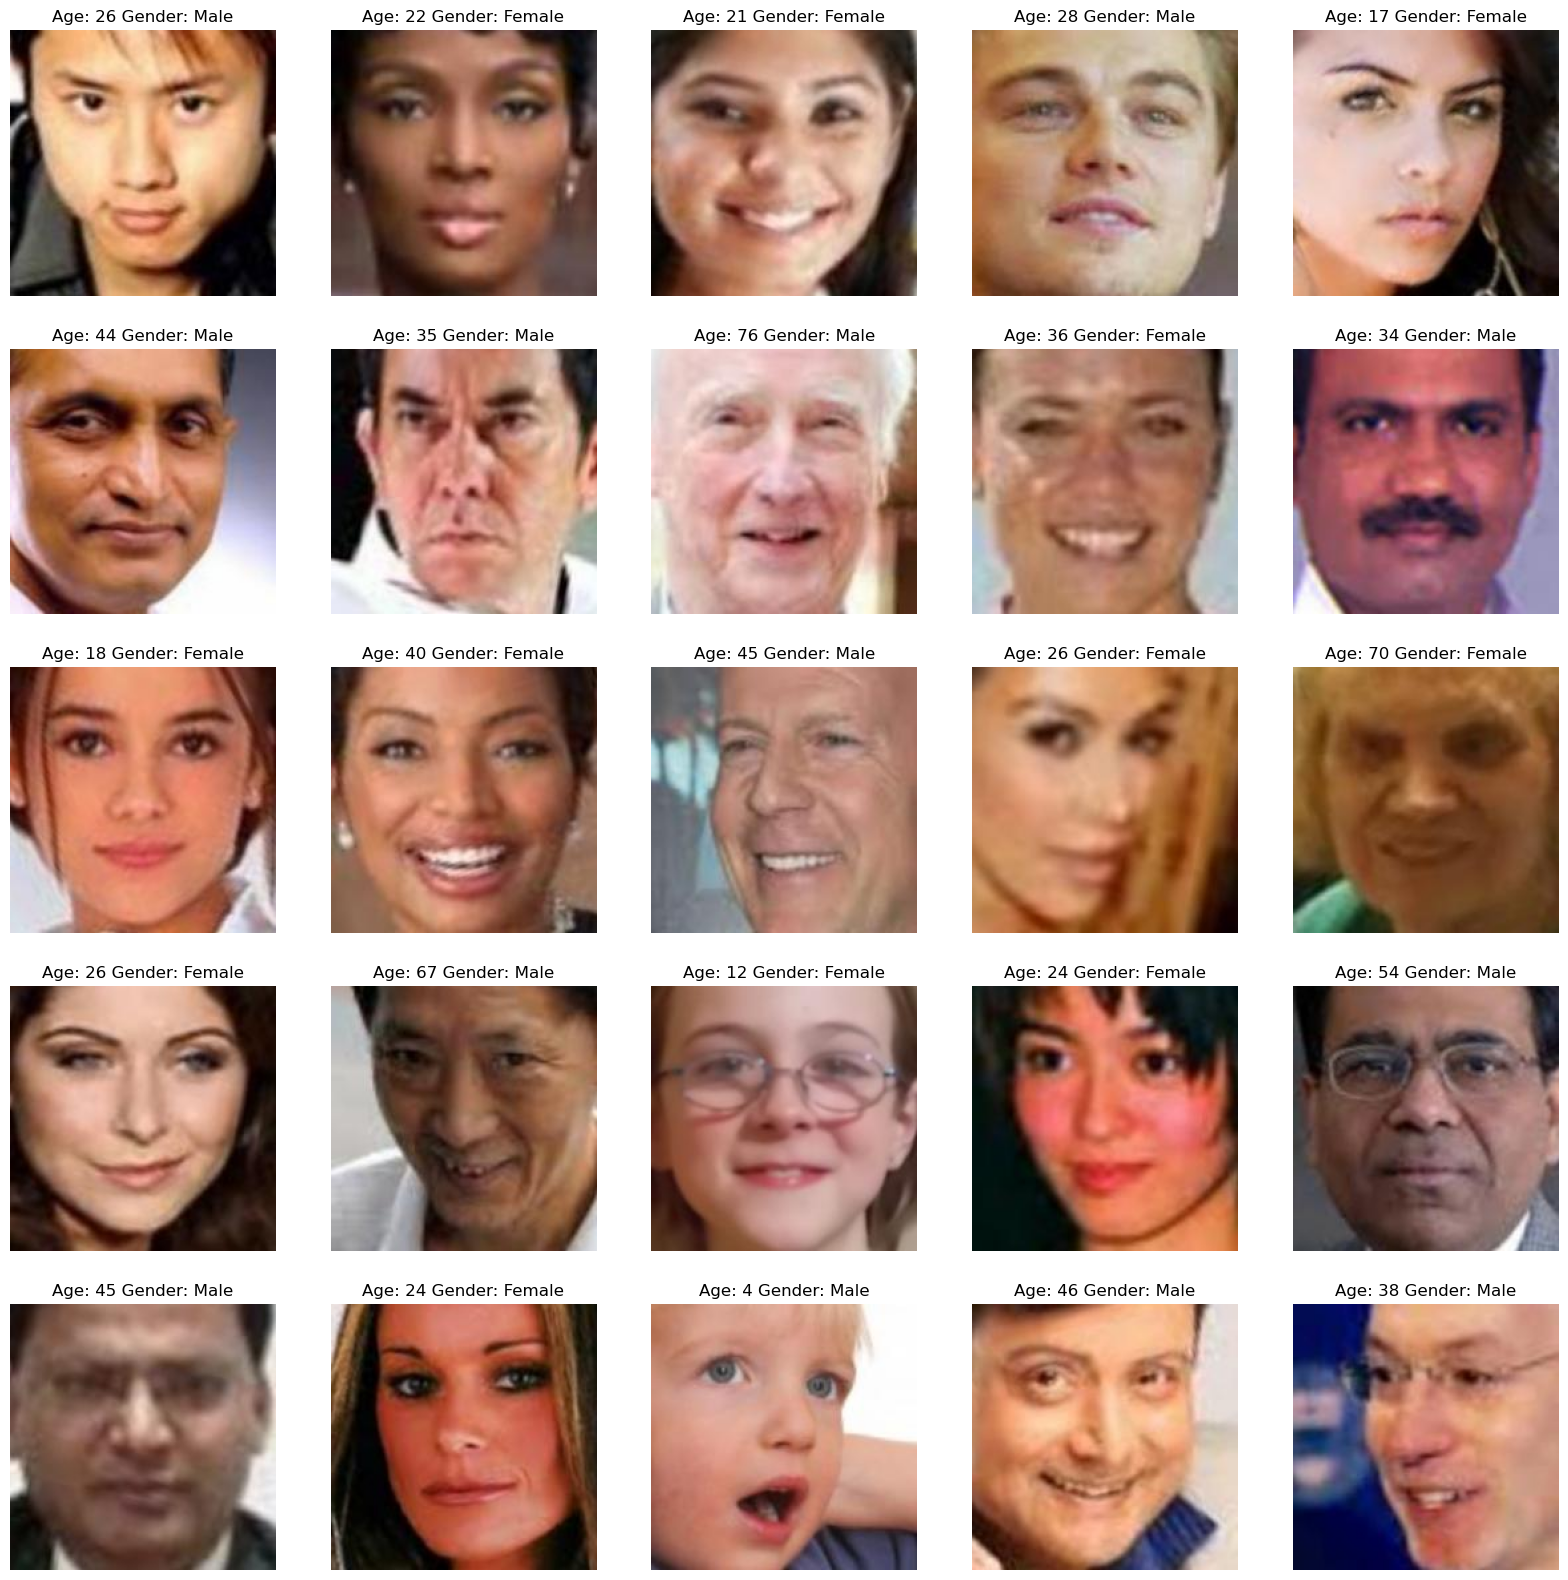

In [11]:
# to display grid of images
plt.figure(figsize=(20, 20))
files = df.iloc[0:25]

for index, file, age, gender in files.itertuples():
    plt.subplot(5, 5, index+1)
    img = load_img(file)
    img = np.array(img)
    plt.imshow(img)
    plt.title(f"Age: {age} Gender: {gender_dict[gender]}")
    plt.axis('off')

In [12]:
def extract_features(images):
    features = []
    for image in tqdm(images):
        img = load_img(image, grayscale=True)
        img = img.resize((128, 128), Image.ANTIALIAS)
        img = np.array(img)
        features.append(img)
        
    features = np.array(features)
    # ignore this step if using RGB
    features = features.reshape(len(features), 128, 128, 1)
    return features

In [13]:
X = extract_features(df['image'])

  0%|          | 0/23708 [00:00<?, ?it/s]

In [14]:
X.shape

(23708, 128, 128, 1)

In [15]:
X = X/255.0

In [16]:
y_gender = np.array(df['gender'])
y_age = np.array(df['age'])

In [17]:
input_shape = (128, 128, 1)

In [18]:
inputs = Input((input_shape))
# convolutional layers
conv_1 = Conv2D(32, kernel_size=(3, 3), activation='relu') (inputs)
maxp_1 = MaxPooling2D(pool_size=(2, 2)) (conv_1)
conv_2 = Conv2D(64, kernel_size=(3, 3), activation='relu') (maxp_1)
maxp_2 = MaxPooling2D(pool_size=(2, 2)) (conv_2)
conv_3 = Conv2D(128, kernel_size=(3, 3), activation='relu') (maxp_2)
maxp_3 = MaxPooling2D(pool_size=(2, 2)) (conv_3)
conv_4 = Conv2D(256, kernel_size=(3, 3), activation='relu') (maxp_3)
maxp_4 = MaxPooling2D(pool_size=(2, 2)) (conv_4)

flatten = Flatten() (maxp_4)

# fully connected layers
dense_1 = Dense(256, activation='relu') (flatten)
dense_2 = Dense(256, activation='relu') (flatten)

dropout_1 = Dropout(0.3) (dense_1)
dropout_2 = Dropout(0.3) (dense_2)

output_1 = Dense(1, activation='sigmoid', name='gender_out') (dropout_1)
output_2 = Dense(1, activation='relu', name='age_out') (dropout_2)

model = Model(inputs=[inputs], outputs=[output_1, output_2])

model.compile(loss=['binary_crossentropy', 'mae'], optimizer='adam', metrics=['accuracy'])

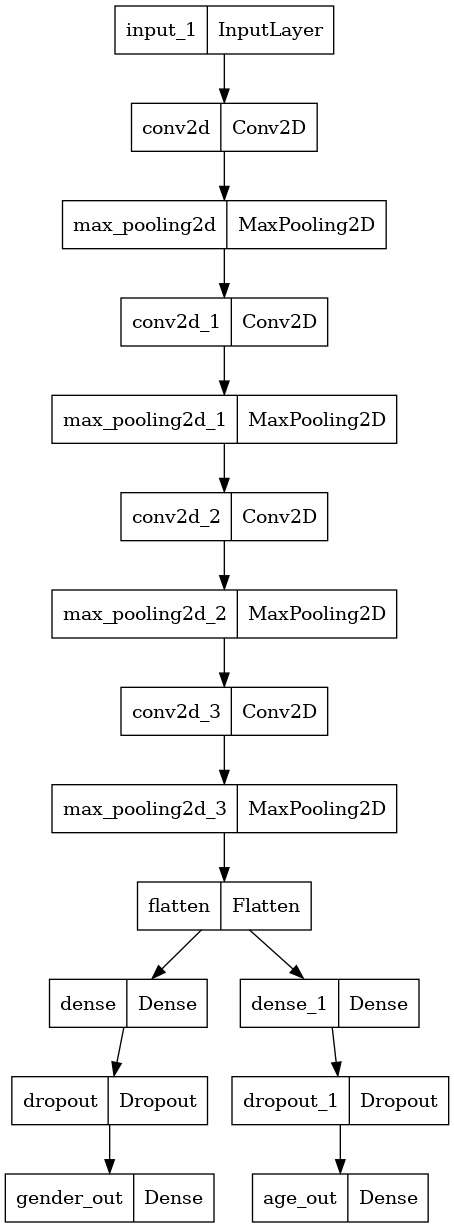

In [19]:
# plot the model
from tensorflow.keras.utils import plot_model
plot_model(model)

In [20]:
# train model
history = model.fit(x=X, y=[y_gender, y_age], batch_size=32, epochs=100, validation_split=0.2)

Epoch 1/100
593/593 [==============================] - 30s 22ms/step - loss: 15.5524 - gender_out_loss: 0.6689 - age_out_loss: 14.8835 - gender_out_accuracy: 0.5763 - age_out_accuracy: 0.0473 - val_loss: 11.9333 - val_gender_out_loss: 0.5322 - val_age_out_loss: 11.4010 - val_gender_out_accuracy: 0.7328 - val_age_out_accuracy: 0.0432
Epoch 2/100
593/593 [==============================] - 12s 19ms/step - loss: 11.5049 - gender_out_loss: 0.4787 - age_out_loss: 11.0262 - gender_out_accuracy: 0.7709 - age_out_accuracy: 0.0255 - val_loss: 10.5991 - val_gender_out_loss: 0.4253 - val_age_out_loss: 10.1738 - val_gender_out_accuracy: 0.8011 - val_age_out_accuracy: 0.0091
Epoch 3/100
593/593 [==============================] - 11s 19ms/step - loss: 9.7754 - gender_out_loss: 0.4175 - age_out_loss: 9.3579 - gender_out_accuracy: 0.8044 - age_out_accuracy: 0.0115 - val_loss: 8.7647 - val_gender_out_loss: 0.3770 - val_age_out_loss: 8.3876 - val_gender_out_accuracy: 0.8254 - val_age_out_accuracy: 0.0089

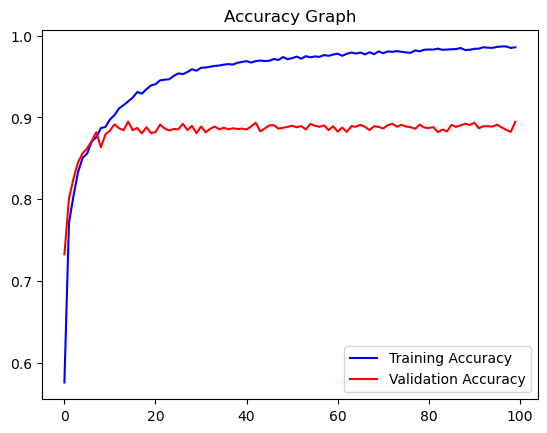

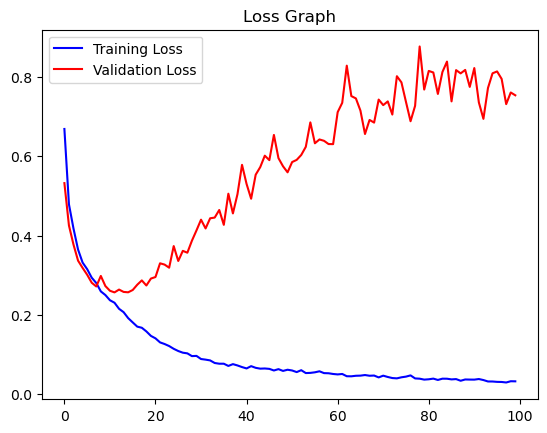

In [21]:
# plot results for gender
acc = history.history['gender_out_accuracy']
val_acc = history.history['val_gender_out_accuracy']
epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Accuracy Graph')
plt.legend()
plt.figure()

loss = history.history['gender_out_loss']
val_loss = history.history['val_gender_out_loss']

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Loss Graph')
plt.legend()
plt.show()

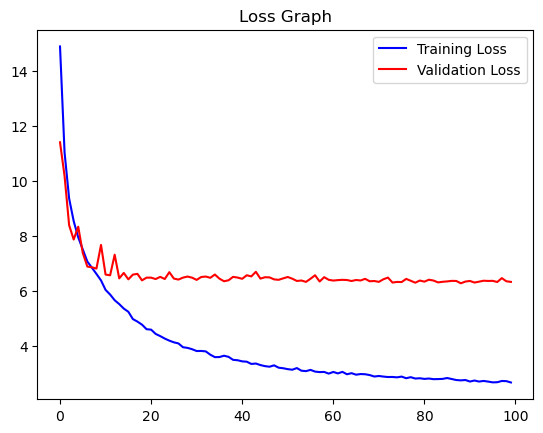

In [22]:
# plot results for age
loss = history.history['age_out_loss']
val_loss = history.history['val_age_out_loss']
epochs = range(len(loss))

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Loss Graph')
plt.legend()
plt.show()

Original Gender: Female Original Age: 3
1/1 [==============================] - 0s 331ms/step
Predicted Gender: Female Predicted Age: 3


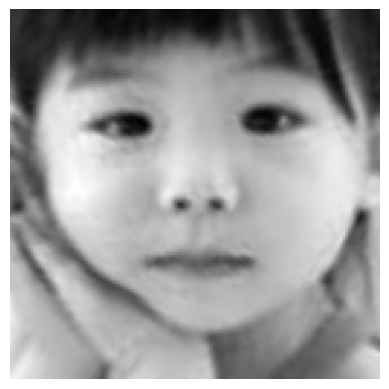

In [23]:
image_index = 100
print("Original Gender:", gender_dict[y_gender[image_index]], "Original Age:", y_age[image_index])
# predict from model
pred = model.predict(X[image_index].reshape(1, 128, 128, 1))
pred_gender = gender_dict[round(pred[0][0][0])]
pred_age = round(pred[1][0][0])
print("Predicted Gender:", pred_gender, "Predicted Age:", pred_age)
plt.axis('off')
plt.imshow(X[image_index].reshape(128, 128), cmap='gray');

Original Gender: Male Original Age: 29
1/1 [==============================] - 0s 20ms/step
Predicted Gender: Male Predicted Age: 27


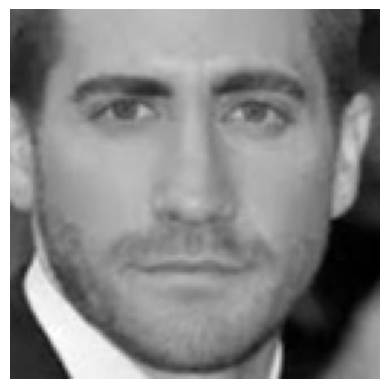

In [24]:
image_index = 150
print("Original Gender:", gender_dict[y_gender[image_index]], "Original Age:", y_age[image_index])
# predict from model
pred = model.predict(X[image_index].reshape(1, 128, 128, 1))
pred_gender = gender_dict[round(pred[0][0][0])]
pred_age = round(pred[1][0][0])
print("Predicted Gender:", pred_gender, "Predicted Age:", pred_age)
plt.axis('off')
plt.imshow(X[image_index].reshape(128, 128), cmap='gray');

Original Gender: Female Original Age: 18
1/1 [==============================] - 0s 20ms/step
Predicted Gender: Female Predicted Age: 18


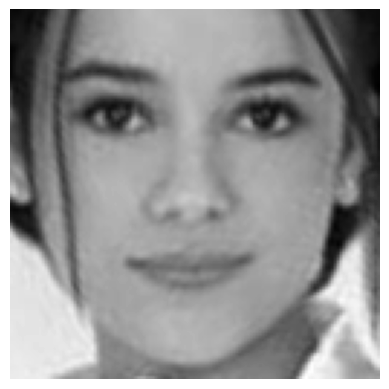

In [25]:
image_index = 10
print("Original Gender:", gender_dict[y_gender[image_index]], "Original Age:", y_age[image_index])
# predict from model
pred = model.predict(X[image_index].reshape(1, 128, 128, 1))
pred_gender = gender_dict[round(pred[0][0][0])]
pred_age = round(pred[1][0][0])
print("Predicted Gender:", pred_gender, "Predicted Age:", pred_age)
plt.axis('off')
plt.imshow(X[image_index].reshape(128, 128), cmap='gray');

Original Gender: Male Original Age: 43
1/1 [==============================] - 0s 20ms/step
Predicted Gender: Male Predicted Age: 40


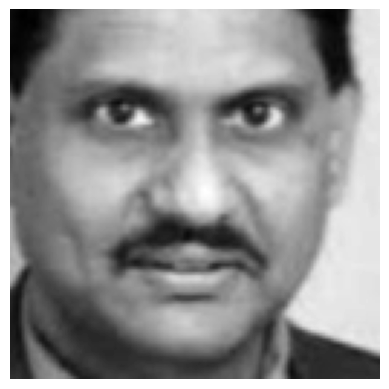

In [26]:
image_index = 1000
print("Original Gender:", gender_dict[y_gender[image_index]], "Original Age:", y_age[image_index])
# predict from model
pred = model.predict(X[image_index].reshape(1, 128, 128, 1))
pred_gender = gender_dict[round(pred[0][0][0])]
pred_age = round(pred[1][0][0])
print("Predicted Gender:", pred_gender, "Predicted Age:", pred_age)
plt.axis('off')
plt.imshow(X[image_index].reshape(128, 128), cmap='gray');

Original Gender: Male Original Age: 1
1/1 [==============================] - 0s 19ms/step
Predicted Gender: Male Predicted Age: 0


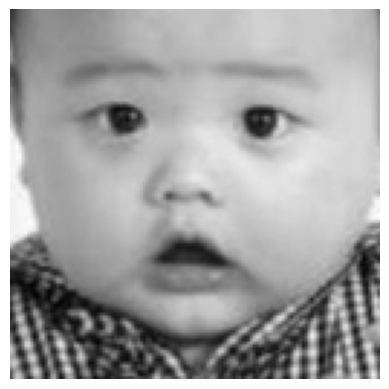

In [27]:
image_index = 777
print("Original Gender:", gender_dict[y_gender[image_index]], "Original Age:", y_age[image_index])
# predict from model
pred = model.predict(X[image_index].reshape(1, 128, 128, 1))
pred_gender = gender_dict[round(pred[0][0][0])]
pred_age = round(pred[1][0][0])
print("Predicted Gender:", pred_gender, "Predicted Age:", pred_age)
plt.axis('off')
plt.imshow(X[image_index].reshape(128, 128), cmap='gray');

Original Gender: Male Original Age: 35
1/1 [==============================] - 0s 23ms/step
Predicted Gender: Male Predicted Age: 37


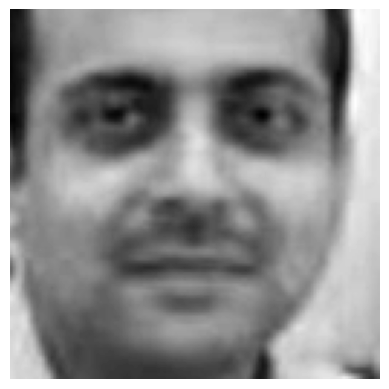

In [28]:
image_index = 179
print("Original Gender:", gender_dict[y_gender[image_index]], "Original Age:", y_age[image_index])
# predict from model
pred = model.predict(X[image_index].reshape(1, 128, 128, 1))
pred_gender = gender_dict[round(pred[0][0][0])]
pred_age = round(pred[1][0][0])
print("Predicted Gender:", pred_gender, "Predicted Age:", pred_age)
plt.axis('off')
plt.imshow(X[image_index].reshape(128, 128), cmap='gray');

In [1]:
!git init
!git config --global user.email "sagnik.amity@gmail.com"
!git config --global user.name "fuck_imlate"


hint: Using 'master' as the name for the initial branch. This default branch name
hint: is subject to change. To configure the initial branch name to use in all
hint: of your new repositories, which will suppress this warning, call:
hint: 
hint: 	git config --global init.defaultBranch <name>
hint: 
hint: Names commonly chosen instead of 'master' are 'main', 'trunk' and
hint: 'development'. The just-created branch can be renamed via this command:
hint: 
hint: 	git branch -m <name>
Initialized empty Git repository in /kaggle/working/.git/


In [2]:
!ls

__notebook_source__.ipynb


In [4]:
cd /kaggle/working/


/kaggle/working


In [5]:
!git add .


In [6]:
!git commit -m "Age and Gender Classification"


[master (root-commit) 1e201fd] Age and Gender Classification
 1 file changed, 16 insertions(+)
 create mode 100644 __notebook_source__.ipynb


In [11]:
!git remote add origin git@github.com:imtommyshelby/Age-and-Gender-Classification.git


error: remote origin already exists.


In [14]:
!openssl version



OpenSSL 3.1.1 30 May 2023 (Library: OpenSSL 3.1.1 30 May 2023)


In [15]:
!git push -u origin master


OpenSSL version mismatch. Built against 30000020, you have 30100010
fatal: Could not read from remote repository.

Please make sure you have the correct access rights
and the repository exists.
